In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt
import optuna
from time import time
from datetime import datetime

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [2]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [3]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [4]:
df_raw.groupby("Rating").size()

Rating
1     97
2     34
3    101
4     91
5    176
dtype: int64

#### Prepare X and Y

In [5]:
RANDOM_STATE = 42
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [6]:
df = df_raw.copy()
df.shape

(499, 13)

In [7]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((499, 12), (499,))

Train/Test Split (Stratified Test)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (474, 12) | Y_train: (474,)
X_test: (25, 12) | Y_test: (25,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([5, 2, 5, 4, 9], dtype=int64))


---

In [9]:
number_of_splits = 5

stratified_shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
stratified_shufflesplit

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None)

In [10]:
score_metric = "roc_auc_ovo" # ROC-AUC One-vs-One Approach

### Objective Functions

In [11]:
# Random Forest

def objective_rf(trial: optuna.Trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150, log=True)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 6, log=True)
    rf_max_features = trial.suggest_int("rf_max_features", 2, X.shape[1], log=True)
    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, max_features=rf_max_features)
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=stratified_shufflesplit)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [12]:
# XGBoost

def objective_xgb(trial= optuna.Trial):
    xgb_gamma = trial.suggest_float("xgb_gamma", 0, 0.5, step=0.01)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.5, step=0.01)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6, log=True)
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 150, log=True)
    classifier_obj = xgb.XGBClassifier(objective='multi:softprob', gamma=xgb_gamma, learning_rate=xgb_learning_rate, 
                                       max_depth=xgb_max_depth, n_estimators=xgb_n_estimators) # XGBClassifier for multi-class classification
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=stratified_shufflesplit)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [13]:
models = {
    "RF": objective_rf,
    "XGB": objective_xgb
}

In [14]:
def build_best_estimator(model: str, params: dict) -> object:
    estimator = None
    match model:
        case "RF": 
            estimator = RandomForestClassifier(n_estimators=params["rf_n_estimators"], max_depth=params["rf_max_depth"], 
                                               max_features=params["rf_max_features"])
        case "XGB":
            estimator = xgb.XGBClassifier(objective='multi:softprob', 
                                          gamma=params["xgb_gamma"], learning_rate=params["xgb_learning_rate"], 
                                          max_depth=params["xgb_max_depth"], n_estimators=params["xgb_n_estimators"])
        case _: pass
    return estimator

#### Run Experiments

In [15]:
n_trials = 50
experiment_name = "First-Experiment"
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [16]:
best_estimators = []
df_results = pd.DataFrame(columns=["model", "score_val", "params"])
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H:%M:%S")

for model, objective_function in models.items():
    study = optuna.create_study(storage="sqlite:///db.sqlite3", study_name=f"{experiment_name}_{model}_{timestamp}", direction="maximize")
    print(f"Fitting {model} ...")
    study.optimize(models[model], n_trials=n_trials, n_jobs=-1)

    print("Fitting best estimator...")
    best_estimator = build_best_estimator(model, study.best_params)
    best_estimator.fit(X_train, Y_train)
    print("Completed!\n")
    
    best_estimators.append((model, best_estimator))
    df_results.loc[len(df_results)] = [model, round(study.best_value, 3), study.best_params]

Fitting RF ...
Fitting best estimator...
Completed!

Fitting XGB ...
Fitting best estimator...
Completed!



In [17]:
df_results

,model,score_val,params
0,RF,0.920,"{'rf_n_estimators': 108, 'rf_max_depth': 5, 'r..."
1,XGB,0.917,"{'xgb_gamma': 0.41000000000000003, 'xgb_learni..."


#### Results on Test Split

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is de

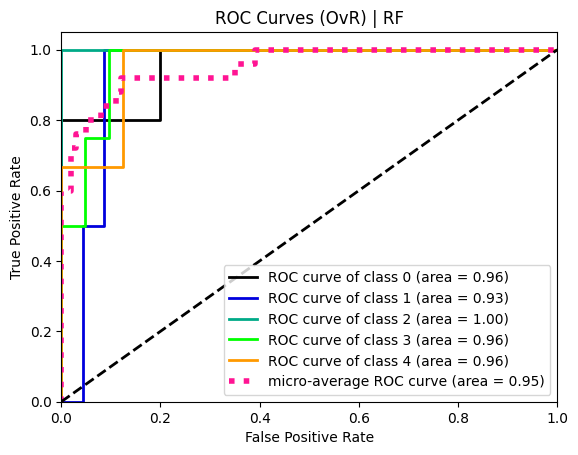

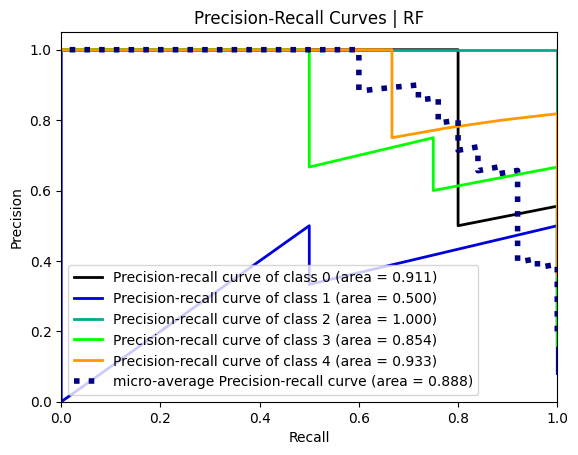

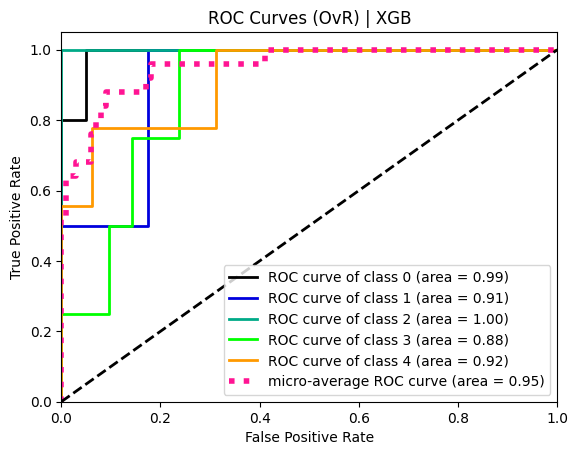

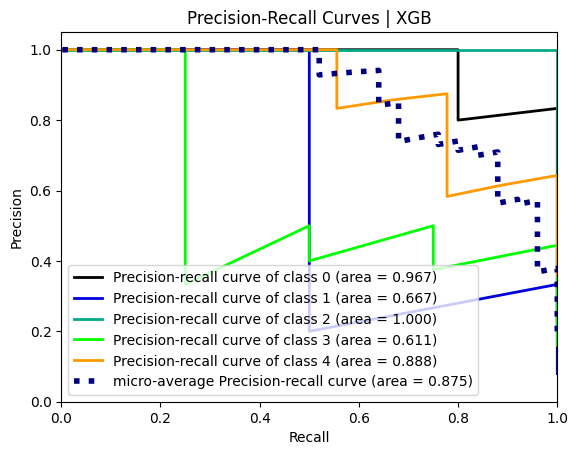

In [20]:
for estimator in best_estimators:
    model_name = estimator[0]
    estimator_obj = estimator[1]
    Y_test_predicted_proba_rf = estimator_obj.predict_proba(X_test)
    skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_rf, title=f"ROC Curves (OvR) | {model_name}", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
    skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_rf, title=f"Precision-Recall Curves | {model_name}")